# Necessities

In [14]:
# ------------------------------------------------------------------
# Imports
# ------------------------------------------------------------------
# Basic data processing libraries
import pandas as pd
import numpy as np
import os
import torch

# Graph data processing libraries
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

# Libraries for (G)NNs
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch.nn as nn

# ------------------------------------------------------------------
# Helper functions
# ------------------------------------------------------------------
def show_df_info(df):
    print(df.info())
    print('####### Repeat ####### \n', df.duplicated().any())
    print('####### Count ####### \n', df.nunique())
    print('####### Example ####### \n',df.head())

def label_statics(label_df, label_list):
    print("####### nCount #######")
    for label in label_list:
        print(label_df[label].value_counts())
    print("####### nPercent #######")
    for label in label_list:
        print(label_df[label].value_counts()/label_df.shape[0])

# ------------------------------------------------------------------
# Data stuff
# ------------------------------------------------------------------
base_path = os.getcwd()
input_ali_data_path = base_path

# Load the data files
user_labels_path = os.path.join(input_ali_data_path, "nba.csv")
user_edges_path = os.path.join(input_ali_data_path, "nba_relationship.csv")

# Create dataframes to store the information from the .csv files
user_labels = pd.read_csv(user_labels_path)
user_edges = pd.read_csv(user_edges_path)

In [15]:
def set_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
user_edges

,uid1,uid2
0,55371339,188621689
1,430230487,92337777
2,164109237,725731259612196864
3,164109237,3181228674
4,164109237,184139015
...,...,...
16565,95649322,41861751
16566,95649322,153307097
16567,95649322,272116860
16568,95649322,70926844


In [17]:
user_labels

,user_id,SALARY,AGE,MP,FG,FGA,FG%,3P,3PA,3P%,...,ORL/TOR,PHI,PHI/OKC,PHX,POR,SA,SAC,TOR,UTAH,WSH
0,105305397,-1,25,14.8,2.7,5.6,0.487,0.8,2.1,0.374,...,0,0,0,0,0,0,0,0,0,0
1,49680175,-1,32,4.9,0.9,2.4,0.383,0.6,1.4,0.400,...,0,0,0,0,0,0,0,0,0,0
2,364013199,0,20,20.1,2.4,5.9,0.399,0.6,2.0,0.321,...,0,0,0,0,0,0,0,0,0,0
3,234811698,0,25,14.0,2.1,4.8,0.440,0.5,1.4,0.337,...,0,0,0,0,0,0,0,0,0,0
4,1031967637561954304,1,28,8.4,2.1,3.8,0.545,0.0,0.0,0.000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,24342206,1,39,18.7,2.5,6.4,0.390,1.3,3.3,0.392,...,0,0,0,0,0,1,0,0,0,0
399,270689028,1,26,34.7,8.1,18.3,0.444,3.0,7.6,0.399,...,0,0,0,0,0,0,0,0,0,0
400,47218790,-1,29,25.1,3.4,7.6,0.454,0.5,1.7,0.288,...,0,0,0,0,0,0,1,0,0,0
401,42562446,1,28,33.4,8.5,18.3,0.468,4.1,10.0,0.411,...,0,0,0,0,0,0,0,0,0,0


In [18]:
show_df_info(user_labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 98 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        403 non-null    int64  
 1   SALARY         403 non-null    int64  
 2   AGE            403 non-null    int64  
 3   MP             403 non-null    float64
 4   FG             403 non-null    float64
 5   FGA            403 non-null    float64
 6   FG%            403 non-null    float64
 7   3P             403 non-null    float64
 8   3PA            403 non-null    float64
 9   3P%            403 non-null    float64
 10  2P             403 non-null    float64
 11  2PA            403 non-null    float64
 12  2P%            403 non-null    float64
 13  eFG%           403 non-null    float64
 14  FT             403 non-null    float64
 15  FTA            403 non-null    float64
 16  FT%            403 non-null    float64
 17  ORB            403 non-null    float64
 18  DRB       

In [19]:
label_statics(user_labels, ['country', 'SALARY'])

####### nCount #######
0    296
1    107
Name: country, dtype: int64
 1    159
 0    154
-1     90
Name: SALARY, dtype: int64
####### nPercent #######
0    0.734491
1    0.265509
Name: country, dtype: float64
 1    0.394541
 0    0.382134
-1    0.223325
Name: SALARY, dtype: float64


## Continue Data Prep

In [20]:
user_edges = user_edges[user_edges['uid1'].isin(user_labels['user_id']) & user_edges['uid2'].isin(user_labels['user_id'])]
user_edges, user_edges.shape

(            uid1                uid2
 0       55371339           188621689
 1      430230487            92337777
 2      164109237  725731259612196864
 3      164109237          3181228674
 4      164109237           184139015
 ...          ...                 ...
 16565   95649322            41861751
 16566   95649322           153307097
 16567   95649322           272116860
 16568   95649322            70926844
 16569   95649322           150367583
 
 [16570 rows x 2 columns],
 (16570, 2))

In [21]:
# Extract node features from user_labels dataframe
node_features = user_labels.iloc[:, 1:] 
node_features = torch.tensor(node_features.values, dtype=torch.float)

# Extract edges from user_edges dataframe
edges = user_edges[['uid1', 'uid2']]
edges['uid1'] = edges['uid1'].map(dict(zip(user_labels['user_id'], range(len(user_labels)))))
edges['uid2'] = edges['uid2'].map(dict(zip(user_labels['user_id'], range(len(user_labels)))))

# Convert edges dataframe to tensor
edges_tensor = torch.tensor(edges.values, dtype=torch.long).t().contiguous()

# Create edge_index tensor
edge_index = edges_tensor

In [22]:
user_labels['SALARY'] = user_labels['SALARY'].map({-1: 0, 0: 1, 1: 1})

In [23]:
# Prepare the data for GNNs
# node_features = torch.tensor(user_labels.iloc[:, 1:].values, dtype=torch.float)
# edge_index = torch.tensor(user_edges.values, dtype=torch.long).t().contiguous()

# node_features = torch.tensor(filtered_user_labels.iloc[:, 1:].values, dtype=torch.float)
# edge_index = torch.tensor(filtered_edges.values, dtype=torch.long).t().contiguous()

# Create torch-geometric data
data = Data(x=node_features, edge_index=edge_index)

num_nodes = node_features.size(0)
num_classes = 2 
num_node_features = data.num_node_features

# Create masks for training, and testing
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# 80 - 20 Train and Test data split
num_train = int(num_nodes * 0.8)
train_mask[:num_train] = True
test_mask[num_train:] = True

data.train_mask = train_mask
data.test_mask = test_mask

# Labels from the data (in this case: Job Classification)
data.y = torch.tensor(user_labels['SALARY'].values, dtype=torch.long)

In [24]:
label_statics(user_labels, ['country', 'SALARY'])

####### nCount #######
0    296
1    107
Name: country, dtype: int64
1    313
0     90
Name: SALARY, dtype: int64
####### nPercent #######
0    0.734491
1    0.265509
Name: country, dtype: float64
1    0.776675
0    0.223325
Name: SALARY, dtype: float64


In [25]:
node_features.shape, edge_index.shape, data.y.shape

(torch.Size([403, 97]), torch.Size([2, 16570]), torch.Size([403]))

In [26]:
print(data, num_nodes, train_mask.size(), test_mask.size())

Data(x=[403, 97], edge_index=[2, 16570], train_mask=[403], test_mask=[403], y=[403]) 403 torch.Size([403]) torch.Size([403])


In [27]:
data.x.shape, data.y.shape

(torch.Size([403, 97]), torch.Size([403]))

# Loss Functions

In [28]:
def fairness_aware_loss(output, data, sensitive_attr, alpha=0, beta=0, gamma=0, delta=0):
    target = data.y[data.train_mask]
    standard_loss = F.cross_entropy(output, target)

    labels = data.y[train_mask]
    pos_prob = torch.sigmoid(output[:, 1])
    neg_prob = 1 - pos_prob
    predictions = output.argmax(dim=1)

    # Statistical Parity Regularization
    sp_reg = torch.abs(pos_prob[sensitive_attr == 1].mean() - pos_prob[sensitive_attr == 0].mean())

    # # Calculating FPR and TPR for each group
    # fpr_group1 = ((predictions == 1) & (labels == 0) & (sensitive_attr == 1)).float().mean()
    # fpr_group0 = ((predictions == 1) & (labels == 0) & (sensitive_attr == 0)).float().mean()
    # tpr_group1 = ((predictions == 1) & (labels == 1) & (sensitive_attr == 1)).float().mean()
    # tpr_group0 = ((predictions == 1) & (labels == 1) & (sensitive_attr == 0)).float().mean()

    # Treatment Equality Regularization
    fp_diff = (neg_prob * (labels == 0) * (sensitive_attr == 1)).float().mean() - \
              (neg_prob * (labels == 0) * (sensitive_attr == 0)).float().mean()
    fn_diff = (pos_prob * (labels == 1) * (sensitive_attr == 1)).float().mean() - \
              (pos_prob * (labels == 1) * (sensitive_attr == 0)).float().mean()
    treatment_reg = torch.abs(fp_diff) + torch.abs(fn_diff)
    # treatment_reg = torch.abs(fn_diff)

    # fn_group_1 = ((predictions == 0) & (labels == 1) & (sensitive_attr == 1)).sum()
    # fp_group_1 = ((predictions == 1) & (labels == 0) & (sensitive_attr == 1)).sum()

    # fn_group_0 = ((predictions == 0) & (labels == 1) & (sensitive_attr == 0)).sum()
    # fp_group_0 = ((predictions == 1) & (labels == 0) & (sensitive_attr == 0)).sum()
    
    # ratio_group_1 = fn_group_1 / fp_group_1 if fp_group_1 != 0 else torch.tensor(float('inf'))
    # ratio_group_0 = fn_group_0 / fp_group_0 if fp_group_0 != 0 else torch.tensor(float('inf'))
    # treatment_reg = torch.abs(ratio_group_1 - ratio_group_0)

    # Equal Opportunity Difference Regularization
    eod_reg = torch.abs((pos_prob * (labels == 1) * (sensitive_attr == 1)).float().mean() - \
                        (pos_prob * (labels == 1) * (sensitive_attr == 0)).float().mean())

    # Overall Accuracy Equality Difference Regularization
    oaed_reg = torch.abs((pos_prob * (sensitive_attr == 1)).float().mean() - \
                         (pos_prob * (sensitive_attr == 0)).float().mean())

    penalty = alpha + beta + gamma + delta
    
    # Combine losses
    combined_loss = (1-penalty)*standard_loss
    + alpha * sp_reg
    + beta * treatment_reg
    + gamma * eod_reg
    + delta * oaed_reg
    
    return combined_loss

# Calculate Fairness

In [29]:
def calculate_fairness(label, predictions, sens_attr='country', balanced=False):
    """
    Calculate various fairness metrics.

    Args:
    label: Actual labels (binary).
    predictions: Model predictions (binary).
    sens_attr: Binary sensitive attribute for fairness evaluation.

    Returns:
    A dictionary containing SPD, EOD, OAED, and TED values.
    """
    if balanced is False:
        labels = torch.tensor(user_labels[label].values, dtype=torch.long)
        sensitive_attribute = torch.tensor(user_labels[sens_attr].values, dtype=torch.long)
    else:
        labels = torch.tensor(filtered_user_labels[label].values, dtype=torch.long)
        sensitive_attribute = torch.tensor(filtered_user_labels[sens_attr].values, dtype=torch.long)
    
    labels = labels.to(set_device())
    sensitive_attribute = sensitive_attribute.to(set_device())

    predictions = predictions.float()
    labels = labels.float()
    sensitive_attribute = sensitive_attribute.float()

    print("Labels on device: ", labels.device)
    print("Sensitive attribute on device: ", sensitive_attribute.device)
    print("Predictions on device: ", predictions.device)

    def statistical_parity_difference():
        prob_group_1 = predictions[sensitive_attribute == 1].mean()
        prob_group_0 = predictions[sensitive_attribute == 0].mean()
        return abs(prob_group_1 - prob_group_0), prob_group_0, prob_group_1

    def equal_opportunity_difference():
        tpr_group_1 = predictions[(labels == 1) & (sensitive_attribute == 1)].mean()
        tpr_group_0 = predictions[(labels == 1) & (sensitive_attribute == 0)].mean()
        return abs(tpr_group_1 - tpr_group_0), tpr_group_0, tpr_group_1

    def overall_accuracy_equality_difference():
        acc_group_1 = (predictions[sensitive_attribute == 1] == labels[sensitive_attribute == 1]).float().mean()
        acc_group_0 = (predictions[sensitive_attribute == 0] == labels[sensitive_attribute == 0]).float().mean()
        return abs(acc_group_1 - acc_group_0), acc_group_0, acc_group_1

    def treatment_equality_difference():
        fn_group_1 = ((predictions == 0) & (labels == 1) & (sensitive_attribute == 1)).sum()
        fp_group_1 = ((predictions == 1) & (labels == 0) & (sensitive_attribute == 1)).sum()

        fn_group_0 = ((predictions == 0) & (labels == 1) & (sensitive_attribute == 0)).sum()
        fp_group_0 = ((predictions == 1) & (labels == 0) & (sensitive_attribute == 0)).sum()

        ratio_group_1 = fn_group_1 / fp_group_1 if fp_group_1 != 0 else float('inf')
        ratio_group_0 = fn_group_0 / fp_group_0 if fp_group_0 != 0 else float('inf')

        return abs(ratio_group_1 - ratio_group_0), ratio_group_0, ratio_group_1, fn_group_1, fp_group_1, fn_group_0, fp_group_0

    # Calculating each fairness metric
    spd, sp_g0, sp_g1 = statistical_parity_difference()
    eod, eod_g0, eod_g1 = equal_opportunity_difference()
    oaed, oaed_g0, oaed_g1 = overall_accuracy_equality_difference()
    ted, ted_g0, ted_g1, fn_group_1, fp_group_1, fn_group_0, fp_group_0 = treatment_equality_difference()

    return {
        'Statistical Parity Difference': spd,
        'Statistical Parity Group with S=0': sp_g0,
        'Statistical Parity Group S=1': sp_g1,
        'Equal Opportunity Difference': eod,
        'Equal Opportunity Group with S=0': eod_g0,
        'Equal Opportunity Group S=1': eod_g1,
        'Overall Accuracy Equality Difference': oaed,
        'Overall Accuracy Group with S=0': oaed_g0,
        'Overall Accuracy Group S=1': oaed_g1,
        'Treatment Equality Difference': ted,
        'Treatment Equality Group with S=0': ted_g0,
        'Treatment Equality Group S=1': ted_g1,
        'False Negatives Group 1': fn_group_1,
        'False Positives Group 1': fp_group_1,
        'False Negatives Group 0': fn_group_0,
        'False Positives Group 0': fp_group_0
    }

In [30]:
def calculate_fairness(label, predictions, sens_attr='region', balanced=False):
    
    labels = user_labels[label].values
    # labels = labels.astype(float)

    predictions = predictions.int()
    # predictions = predictions.float()

    sens_attr_values = user_labels[sens_attr].values
    # sens_attr_values = sens_attr_values.astype(float)    
    
    predictions = predictions.to('cpu')

    # Indices for privileged and unprivileged groups    
    privileged_indices = sens_attr_values == 1
    unprivileged_indices = sens_attr_values == 0
    
    # Calculating metrics for both groups
    def calc_metrics(preds, lbls):
        tp = ((preds == 1) & (lbls == 1)).sum().item()
        tn = ((preds == 0) & (lbls == 0)).sum().item()
        fp = ((preds == 1) & (lbls == 0)).sum().item()
        fn = ((preds == 0) & (lbls == 1)).sum().item()
        
        accuracy = (tp + tn) / max(tp + tn + fp + fn, 1)  # Prevent division by zero
        tpr = tp / max(tp + fn, 1)  # True Positive Rate
        fpr = fp / max(fp + tn, 1)  # False Positive Rate
        
        return accuracy, tpr, fpr, fp, fn
    
    # Metrics for unprivileged
    acc_unpriv, tpr_unpriv, _, fp_unpriv, fn_unpriv = calc_metrics(predictions[unprivileged_indices], labels[unprivileged_indices])
    # Metrics for privileged
    acc_priv, tpr_priv, _, fp_priv, fn_priv = calc_metrics(predictions[privileged_indices], labels[privileged_indices])
    
    # Statistical Parity for both groups
    sp_unpriv = predictions[unprivileged_indices].float().mean().item()
    sp_priv = predictions[privileged_indices].float().mean().item()
    
    # Calculating fairness metrics differences
    spd = sp_priv - sp_unpriv  # Statistical Parity Difference
    oaed = acc_priv - acc_unpriv  # Overall Accuracy Equality Difference
    eod = tpr_priv - tpr_unpriv  # Equal Opportunity Difference
    
    # Treatment Equality for both groups
    ted_unpriv = fp_unpriv / max(fn_unpriv, 1) if fn_unpriv != 0 else float('inf')  # Avoid division by zero
    ted_priv = fp_priv / max(fn_priv, 1) if fn_priv != 0 else float('inf')
    ted_diff = ted_unpriv - ted_priv  # Difference in Treatment Equality

    unique, counts = torch.unique(predictions, return_counts=True)
    prediction_distribution = dict(zip(unique.tolist(), counts.tolist()))

    print("Prediction Distribution:", prediction_distribution)
    
    privileged_preds = predictions[sens_attr_values == 1]
    unprivileged_preds = predictions[sens_attr_values == 0]

    # Analyze distribution for privileged group
    priv_unique, priv_counts = torch.unique(privileged_preds, return_counts=True)
    priv_distribution = dict(zip(priv_unique.tolist(), priv_counts.tolist()))

    # Analyze distribution for unprivileged group
    unpriv_unique, unpriv_counts = torch.unique(unprivileged_preds, return_counts=True)
    unpriv_distribution = dict(zip(unpriv_unique.tolist(), unpriv_counts.tolist()))

    print("Privileged Prediction Distribution:", priv_distribution)
    print("Unprivileged Prediction Distribution:", unpriv_distribution)

    priv_positive_rate = privileged_preds.float().mean().item()
    unpriv_positive_rate = unprivileged_preds.float().mean().item()

    print("Privileged Positive Prediction Rate:", priv_positive_rate)
    print("Unprivileged Positive Prediction Rate:", unpriv_positive_rate)

    
    return {
        'SPD': spd,
        'OAED': oaed,
        'EOD': eod,
        'Treatment Equality Difference': ted_diff,
        'SP_Unprivileged': sp_unpriv,
        'SP_Privileged': sp_priv,
        'OAED_Unprivileged': acc_unpriv,
        'OAED_Privileged': acc_priv,
        'EOD_Unprivileged': tpr_unpriv,
        'EOD_Privileged': tpr_priv,
        'TED_Unprivileged': ted_unpriv,
        'TED_Privileged': ted_priv
    }

# Helper functions

In [31]:
# Train the model
def training(model, data, optimizer, epochs, fairness=False, alpha=0, beta=0, gamma=0, delta=0):
    model.to(set_device())
    data.to(set_device())
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        
        if fairness:
            loss = fairness_aware_loss(out[data.train_mask], data, data.x[data.train_mask, -1],
                                       alpha=alpha, beta=beta, gamma=gamma, delta=delta)
            
        else:
            # criterion = torch.nn.CrossEntropyLoss()
            # criterion = torch.nn.BCELoss()
            criterion = torch.nn.NLLLoss()
            loss = criterion(out[data.train_mask], data.y[data.train_mask])

        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch} | Loss: {loss.item()}')

In [32]:
# Test the model
def test(model, data, balanced=False):
    # model.to('cpu')
    # data.to('cpu')

    model.eval()
    with torch.inference_mode():
      out = model(data.x, data.edge_index)

    _, pred = model(data.x, data.edge_index).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    accuracy = correct / int(data.test_mask.sum())

    predictions = out.argmax(dim=1)

    fairness_metrics = calculate_fairness(label='SALARY', predictions=predictions, sens_attr='country', balanced=balanced)
    fairness_metrics['Accuracy'] = accuracy

    return fairness_metrics


In [33]:
def print_metrics(metrics):
    count = -1

    for key, value in metrics.items():
        count += 1
        if count == 3:
            print(f"\n\n{key} : {value:.5f}")
            count = 0
        else:
            print(f"{key} : {value:.5f}")

# Test the Models

## Baseline

In [30]:
# GCN class that takes in the data as an input for dimensions of the convolutions
class GCN(torch.nn.Module):
    def __init__(self, x, edge_index):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)
        
    def forward(self, x, edge_index, *args, **kwargs):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # x = F.softmax(x, dim=1)
        # return x
        return F.log_softmax(x, dim=1)

In [22]:
data.x.shape

torch.Size([403, 97])

In [23]:
data.edge_index.shape

torch.Size([2, 16570])

In [38]:
# Instantiate the model, define loss function and optimizer
gcn_model = GCN(data.x, data.edge_index)
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01)

In [39]:
# Train the first model: GCN, standard data, NLL loss
training(model=gcn_model, data=data, optimizer=gcn_optimizer, epochs=1000)

Epoch 0 | Loss: 7.059955596923828
Epoch 10 | Loss: 0.7133983969688416
Epoch 20 | Loss: 0.7924556136131287
Epoch 30 | Loss: 0.48287272453308105
Epoch 40 | Loss: 0.6271151900291443
Epoch 50 | Loss: 0.5577574372291565
Epoch 60 | Loss: 0.5050077438354492
Epoch 70 | Loss: 0.4788289964199066
Epoch 80 | Loss: 0.4679057002067566
Epoch 90 | Loss: 0.46833834052085876
Epoch 100 | Loss: 0.46552443504333496
Epoch 110 | Loss: 0.4644697606563568
Epoch 120 | Loss: 0.4634011387825012
Epoch 130 | Loss: 0.46236780285835266
Epoch 140 | Loss: 0.46141692996025085
Epoch 150 | Loss: 0.460529625415802
Epoch 160 | Loss: 0.4596925377845764
Epoch 170 | Loss: 0.4588969349861145
Epoch 180 | Loss: 0.45813390612602234
Epoch 190 | Loss: 0.4573976397514343
Epoch 200 | Loss: 0.4566834270954132
Epoch 210 | Loss: 0.4559875428676605
Epoch 220 | Loss: 0.45530638098716736
Epoch 230 | Loss: 0.4546373188495636
Epoch 240 | Loss: 0.4539785087108612
Epoch 250 | Loss: 0.4533279240131378
Epoch 260 | Loss: 0.45268428325653076
Epoch 

In [40]:
# Test the first model: GCN, standard data, NLL loss
print("Here are the values for the standard GCN model with the standard NLL loss: ")

metrics_base_gcn_model = test(gcn_model, data)
print()
print_metrics(metrics_base_gcn_model)

Here are the values for the standard GCN model with the standard NLL loss: 
Labels on device:  cuda:0
Sensitive attribute on device:  cuda:0
Predictions on device:  cuda:0

Statistical Parity Difference : 0.01216
Statistical Parity Group with S=0 : 0.95608
Statistical Parity Group S=1 : 0.94393


Equal Opportunity Difference : 0.01304
Equal Opportunity Group with S=0 : 0.98696
Equal Opportunity Group S=1 : 1.00000


Overall Accuracy Equality Difference : 0.03110
Overall Accuracy Group with S=0 : 0.80068
Overall Accuracy Group S=1 : 0.83178


Treatment Equality Difference : 0.05357
Treatment Equality Group with S=0 : 0.05357
Treatment Equality Group S=1 : 0.00000


False Negatives Group 1 : 0.00000
False Positives Group 1 : 18.00000
False Negatives Group 0 : 3.00000


False Positives Group 0 : 56.00000
Accuracy : 0.75309


In [154]:
# Test the first model: GCN, standard data, NLL loss
print("Here are the values for the standard GCN model with the standard NLL loss: ")

metrics_base_gcn_model = test(gcn_model, data)
print()
print_metrics(metrics_base_gcn_model)

Here are the values for the standard GCN model with the standard NLL loss: 
Prediction Distribution: {0: 23, 1: 380}
Privileged Prediction Distribution: {0: 7, 1: 100}
Unprivileged Prediction Distribution: {0: 16, 1: 280}
Privileged Positive Prediction Rate: 0.9345794320106506
Unprivileged Positive Prediction Rate: 0.9459459185600281

SPD : -0.01137
OAED : 0.02513
EOD : 0.00969


Treatment Equality Difference : -7.00000
SP_Unprivileged : 0.94595
SP_Privileged : 0.93458


OAED_Unprivileged : 0.79730
OAED_Privileged : 0.82243
EOD_Unprivileged : 0.97826


EOD_Privileged : 0.98795
TED_Unprivileged : 11.00000
TED_Privileged : 18.00000


Accuracy : 0.74074


In [42]:
from torch_geometric.explain import Explainer, GNNExplainer

explainer = Explainer(
    model=gcn_model,
    algorithm=GNNExplainer(epochs=50),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs', 
    ),
)

In [43]:
explanation = explainer(data.x, edge_index)
print(explanation.edge_mask)
print(explanation.node_mask)

tensor([0.3742, 0.3539, 0.3692,  ..., 0.3750, 0.3746, 0.3753])
tensor([[0.4206, 0.4052, 0.3808,  ..., 0.0000, 0.0000, 0.0000],
        [0.3945, 0.3694, 0.3747,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3753, 0.4082,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.3973, 0.3880, 0.4192,  ..., 0.0000, 0.0000, 0.0000],
        [0.3506, 0.4383, 0.4063,  ..., 0.0000, 0.0000, 0.0000],
        [0.4261, 0.4202, 0.3942,  ..., 0.0000, 0.0000, 0.0000]])


In [44]:
user_labels

,user_id,SALARY,AGE,MP,FG,FGA,FG%,3P,3PA,3P%,...,ORL/TOR,PHI,PHI/OKC,PHX,POR,SA,SAC,TOR,UTAH,WSH
0,105305397,0,25,14.8,2.7,5.6,0.487,0.8,2.1,0.374,...,0,0,0,0,0,0,0,0,0,0
1,49680175,0,32,4.9,0.9,2.4,0.383,0.6,1.4,0.400,...,0,0,0,0,0,0,0,0,0,0
2,364013199,0,20,20.1,2.4,5.9,0.399,0.6,2.0,0.321,...,0,0,0,0,0,0,0,0,0,0
3,234811698,0,25,14.0,2.1,4.8,0.440,0.5,1.4,0.337,...,0,0,0,0,0,0,0,0,0,0
4,1031967637561954304,1,28,8.4,2.1,3.8,0.545,0.0,0.0,0.000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,24342206,1,39,18.7,2.5,6.4,0.390,1.3,3.3,0.392,...,0,0,0,0,0,1,0,0,0,0
399,270689028,1,26,34.7,8.1,18.3,0.444,3.0,7.6,0.399,...,0,0,0,0,0,0,0,0,0,0
400,47218790,0,29,25.1,3.4,7.6,0.454,0.5,1.7,0.288,...,0,0,0,0,0,0,1,0,0,0
401,42562446,1,28,33.4,8.5,18.3,0.468,4.1,10.0,0.411,...,0,0,0,0,0,0,0,0,0,0


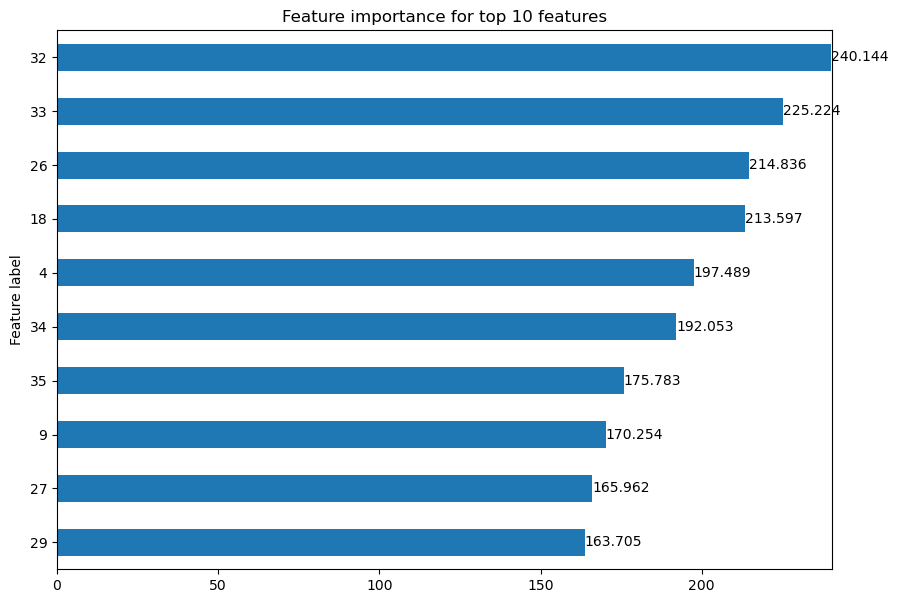

In [45]:
explanation.visualize_feature_importance(top_k=10)

## Fair Models

In [21]:
class FairnessAwareMessagePassingLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(FairnessAwareMessagePassingLayer, self).__init__(aggr='mean')  
        self.lin = nn.Linear(in_channels, out_channels)
        self.a_fair = nn.Parameter(torch.rand(out_channels)) 
        # self.sensitive_attr = torch.tensor(user_labels['country'].values, dtype=torch.float) 
        # self.sensitive_attr = data.x[:, 5] #check and set correctly 
        self.bias_correction = nn.Parameter(torch.rand(1))

    def forward(self, x, edge_index):
        # Add self-loops 
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        x = self.lin(x)

        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)
    
    def message(self, x_j, edge_index, size):
        row, col = edge_index
        deg = degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Compute statistical parity difference for each edge
        group_difference = self.sensitive_attr[row] - self.sensitive_attr[col]
        
        # Adjust messages based on statistical parity
        fairness_adjustment = (1 + self.bias_correction * group_difference.view(-1, 1))

        return fairness_adjustment * norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        return aggr_out * self.a_fair

In [22]:
class custom_GCN(torch.nn.Module):
    def __init__(self, data):
        super(custom_GCN, self).__init__()
        self.conv1 = FairnessAwareMessagePassingLayer(data.num_node_features, 16)
        self.conv2 = FairnessAwareMessagePassingLayer(16, 2) # 2 output classes for gender

    def forward(self, x, edge_index, *args, **kwargs):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

### First Fair Model

This model is an instantiation of the `custom_GCN` using the standard cross-entropy loss.

In [ ]:
torch.optim.SGD: Stochastic Gradient Descent optimizer.
torch.optim.Adam: Adam optimizer.
torch.optim.Adagrad: Adagrad optimizer.
torch.optim.Adadelta: Adadelta optimizer.
torch.optim.RMSprop: RMSprop optimizer.
torch.optim.AdamW: AdamW optimizer.
torch.optim.SparseAdam: SparseAdam optimizer.
torch.optim.LBFGS: L-BFGS optimizer.
torch.optim.Rprop: Rprop optimizer.

In [23]:
model2 = custom_GCN(data)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)

# Train the model: Custom MP GNN, cross-entropy loss
training(model=model2, data=data, optimizer=optimizer2, epochs=1000)

Epoch 0 | Loss: 0.6950044631958008
Epoch 10 | Loss: 0.6877216696739197
Epoch 20 | Loss: 0.6860019564628601
Epoch 30 | Loss: 0.6852525472640991
Epoch 40 | Loss: 0.6845036745071411
Epoch 50 | Loss: 0.6834521889686584
Epoch 60 | Loss: 0.6819733381271362
Epoch 70 | Loss: 0.6798995137214661
Epoch 80 | Loss: 0.6769739389419556
Epoch 90 | Loss: 0.6725189685821533
Epoch 100 | Loss: 0.6645283102989197
Epoch 110 | Loss: 0.6504476070404053
Epoch 120 | Loss: 0.6287883520126343
Epoch 130 | Loss: 0.6013134717941284
Epoch 140 | Loss: 0.5786999464035034
Epoch 150 | Loss: 0.567398726940155
Epoch 160 | Loss: 0.5606890320777893
Epoch 170 | Loss: 0.55605149269104
Epoch 180 | Loss: 0.5529772639274597
Epoch 190 | Loss: 0.5504505038261414
Epoch 200 | Loss: 0.5480257868766785
Epoch 210 | Loss: 0.54550701379776
Epoch 220 | Loss: 0.5428222417831421
Epoch 230 | Loss: 0.5399263501167297
Epoch 240 | Loss: 0.5367610454559326
Epoch 250 | Loss: 0.5334406495094299
Epoch 260 | Loss: 0.5299265384674072
Epoch 270 | Loss:

In [24]:
# Test the first FAIR model: CustomGNN, cross-entropy loss
print("Here are the values for the CustomGNN model with the standard cross-entropy loss: ")

metrics_custom_gnn_model_1 = test(model2, data)
print()
print_metrics(metrics_custom_gnn_model_1)

Here are the values for the CustomGNN model with the standard cross-entropy loss: 
Prediction Distribution: {0: 30, 1: 373}
Privileged Prediction Distribution: {0: 8, 1: 99}
Unprivileged Prediction Distribution: {0: 22, 1: 274}
Privileged Positive Prediction Rate: 0.9252336621284485
Unprivileged Positive Prediction Rate: 0.9256756901741028

SPD : -0.00044
OAED : 0.00903
EOD : 0.00634


Treatment Equality Difference : -1.71429
SP_Unprivileged : 0.92568
SP_Privileged : 0.92523


OAED_Unprivileged : 0.80405
OAED_Privileged : 0.81308
EOD_Unprivileged : 0.96957


EOD_Privileged : 0.97590
TED_Unprivileged : 7.28571
TED_Privileged : 9.00000


Accuracy : 0.72840


In [27]:
# Test the first FAIR model: CustomGNN, cross-entropy loss
print("Here are the values for the CustomGNN model with the standard cross-entropy loss: ")

metrics_custom_gnn_model_1 = test(model2, data)
print()
print_metrics(metrics_custom_gnn_model_1)

Here are the values for the CustomGNN model with the standard cross-entropy loss: 
Prediction Distribution: {0: 39, 1: 364}
Privileged Prediction Distribution: {0: 10, 1: 97}
Unprivileged Prediction Distribution: {0: 29, 1: 267}
Privileged Positive Prediction Rate: 0.9065420627593994
Unprivileged Positive Prediction Rate: 0.9020270109176636

SPD : 0.00452
OAED : 0.03110
EOD : 0.02373


Treatment Equality Difference : -3.63636
SP_Unprivileged : 0.90203
SP_Privileged : 0.90654


OAED_Unprivileged : 0.80068
OAED_Privileged : 0.83178
EOD_Unprivileged : 0.95217


EOD_Privileged : 0.97590
TED_Unprivileged : 4.36364
TED_Privileged : 8.00000


Accuracy : 0.70370


In [ ]:
SPD : 0.06413
OAED : -0.01326
EOD : 0.09307


Treatment Equality Difference : -5.26667
SP_Unprivileged : 0.49662
SP_Privileged : 0.56075


OAED_Unprivileged : 0.77027
OAED_Privileged : 0.75701
EOD_Unprivileged : 0.83193


EOD_Privileged : 0.92500
TED_Unprivileged : 2.40000
TED_Privileged : 7.66667


Accuracy : 0.70370

### Second Fair Model

This model is an instantiation of the `custom_GCN` using the fair cross-entropy loss.

In [29]:
custom_gnn_model_2 = custom_GCN(data)
optimizer_custom_gnn_model_2 = torch.optim.Adam(custom_gnn_model_2.parameters(), lr=0.01)

fairness=True
alpha, beta, gamma, delta = 0.1, 0.1, 0.1, 0.1

# Train the model: Custom MP GNN, FAIR cross-entropy loss
training(model=custom_gnn_model_2, 
         data=data, 
         optimizer=optimizer_custom_gnn_model_2, 
         fairness=fairness, 
         alpha=alpha, 
         beta=beta, 
         gamma=gamma, 
         delta=delta, 
         epochs=1000)

Epoch 0 | Loss: 0.4254482686519623
Epoch 10 | Loss: 0.4117738902568817
Epoch 20 | Loss: 0.4113517701625824
Epoch 30 | Loss: 0.4107479155063629
Epoch 40 | Loss: 0.41003385186195374
Epoch 50 | Loss: 0.40915536880493164
Epoch 60 | Loss: 0.40795350074768066
Epoch 70 | Loss: 0.4060845375061035
Epoch 80 | Loss: 0.40246859192848206
Epoch 90 | Loss: 0.39417195320129395
Epoch 100 | Loss: 0.3776552975177765
Epoch 110 | Loss: 0.3560972809791565
Epoch 120 | Loss: 0.33953672647476196
Epoch 130 | Loss: 0.3305354118347168
Epoch 140 | Loss: 0.3265801966190338
Epoch 150 | Loss: 0.32426169514656067
Epoch 160 | Loss: 0.3220602571964264
Epoch 170 | Loss: 0.31975382566452026
Epoch 180 | Loss: 0.31733980774879456
Epoch 190 | Loss: 0.3149070143699646
Epoch 200 | Loss: 0.3125245273113251
Epoch 210 | Loss: 0.3103429079055786
Epoch 220 | Loss: 0.3080013692378998
Epoch 230 | Loss: 0.3054915964603424
Epoch 240 | Loss: 0.30289605259895325
Epoch 250 | Loss: 0.30009761452674866
Epoch 260 | Loss: 0.2974262237548828
E

In [30]:
# Test the second FAIR model: CustomGNN, FAIR cross-entropy loss
print("Here are the values for the CustomGNN model with the FAIR standard cross-entropy loss: ")

metrics_custom_gnn_model_2 = test(custom_gnn_model_2, data)
print()
print_metrics(metrics_custom_gnn_model_2)

Here are the values for the CustomGNN model with the FAIR standard cross-entropy loss: 
Prediction Distribution: {0: 36, 1: 367}
Privileged Prediction Distribution: {0: 10, 1: 97}
Unprivileged Prediction Distribution: {0: 26, 1: 270}
Privileged Positive Prediction Rate: 0.9065420627593994
Unprivileged Positive Prediction Rate: 0.912162184715271

SPD : -0.00562
OAED : 0.04641
EOD : 0.02708


Treatment Equality Difference : -9.55556
SP_Unprivileged : 0.91216
SP_Privileged : 0.90654


OAED_Unprivileged : 0.80405
OAED_Privileged : 0.85047
EOD_Unprivileged : 0.96087


EOD_Privileged : 0.98795
TED_Unprivileged : 5.44444
TED_Privileged : 15.00000


Accuracy : 0.71605


In [28]:
# Test the second FAIR model: CustomGNN, FAIR cross-entropy loss
print("Here are the values for the CustomGNN model with the FAIR standard cross-entropy loss: ")

metrics_custom_gnn_model_2 = test(custom_gnn_model_2, data)
print()
print_metrics(metrics_custom_gnn_model_2)

Here are the values for the CustomGNN model with the FAIR standard cross-entropy loss: 
Prediction Distribution: {0: 46, 1: 357}
Privileged Prediction Distribution: {0: 12, 1: 95}
Unprivileged Prediction Distribution: {0: 34, 1: 262}
Privileged Positive Prediction Rate: 0.8878504633903503
Unprivileged Positive Prediction Rate: 0.8851351141929626

SPD : 0.00272
OAED : 0.05993
EOD : 0.04112


Treatment Equality Difference : -3.86667
SP_Unprivileged : 0.88514
SP_Privileged : 0.88785


OAED_Unprivileged : 0.79054
OAED_Privileged : 0.85047
EOD_Unprivileged : 0.93478


EOD_Privileged : 0.97590
TED_Unprivileged : 3.13333
TED_Privileged : 7.00000


Accuracy : 0.69136


In [28]:
custom_gnn_model_2 = custom_GCN(data)
optimizer_custom_gnn_model_2 = torch.optim.Adam(custom_gnn_model_2.parameters(), lr=0.01)

fairness=True
alpha, beta, gamma, delta = 0.1, 0.1, 0.1, 0.1

# Train the model: Custom MP GNN, FAIR cross-entropy loss
training(model=custom_gnn_model_2, 
         data=data, 
         optimizer=optimizer_custom_gnn_model_2, 
         fairness=fairness, 
         alpha=alpha, 
         beta=beta, 
         gamma=gamma, 
         delta=delta, 
         epochs=1000)

Epoch 0 | Loss: 0.4283818006515503
Epoch 10 | Loss: 0.4110504388809204
Epoch 20 | Loss: 0.41055238246917725
Epoch 30 | Loss: 0.40999820828437805
Epoch 40 | Loss: 0.40917593240737915
Epoch 50 | Loss: 0.40783610939979553
Epoch 60 | Loss: 0.40523719787597656
Epoch 70 | Loss: 0.4000367224216461
Epoch 80 | Loss: 0.3906148374080658
Epoch 90 | Loss: 0.37659043073654175
Epoch 100 | Loss: 0.3592928946018219
Epoch 110 | Loss: 0.3450210392475128
Epoch 120 | Loss: 0.33666667342185974
Epoch 130 | Loss: 0.33226776123046875
Epoch 140 | Loss: 0.32896682620048523
Epoch 150 | Loss: 0.32094353437423706
Epoch 160 | Loss: 0.304307758808136
Epoch 170 | Loss: 0.2959948182106018
Epoch 180 | Loss: 0.29064521193504333
Epoch 190 | Loss: 0.287928968667984
Epoch 200 | Loss: 0.2862420082092285
Epoch 210 | Loss: 0.3039364218711853
Epoch 220 | Loss: 0.2859782874584198
Epoch 230 | Loss: 0.29414093494415283
Epoch 240 | Loss: 0.28795966506004333
Epoch 250 | Loss: 0.2881815433502197
Epoch 260 | Loss: 0.28648123145103455


In [29]:
# Test the second FAIR model: CustomGNN, FAIR cross-entropy loss
print("Here are the values for the CustomGNN model with the FAIR standard cross-entropy loss: ")

metrics_custom_gnn_model_2 = test(custom_gnn_model_2, data)
print()
print_metrics(metrics_custom_gnn_model_2)

Here are the values for the CustomGNN model with the FAIR standard cross-entropy loss: 
Prediction Distribution: {0: 26, 1: 377}
Privileged Prediction Distribution: {0: 8, 1: 99}
Unprivileged Prediction Distribution: {0: 18, 1: 278}
Privileged Positive Prediction Rate: 0.9252336621284485
Unprivileged Positive Prediction Rate: 0.9391891956329346

SPD : -0.01396
OAED : 0.01579
EOD : 0.00199


Treatment Equality Difference : 0.00000
SP_Unprivileged : 0.93919
SP_Privileged : 0.92523


OAED_Unprivileged : 0.79730
OAED_Privileged : 0.81308
EOD_Unprivileged : 0.97391


EOD_Privileged : 0.97590
TED_Unprivileged : 9.00000
TED_Privileged : 9.00000


Accuracy : 0.74074


### Third FAIR Model

This model is an instantiation of the `custom_GCN` using the fair cross-entropy loss using ONLY large treatment equality penalty.

In [30]:
custom_gnn_model_3 = custom_GCN(data)
optimizer_custom_gnn_model_3 = torch.optim.Adam(custom_gnn_model_3.parameters(), lr=0.01)

fairness=True
alpha, beta, gamma, delta = 0, 0.4, 0, 0

# Train the model: Custom MP GNN, FAIR cross-entropy loss
training(model=custom_gnn_model_3, 
         data=data, 
         optimizer=optimizer_custom_gnn_model_3, 
         fairness=fairness, 
         alpha=alpha, 
         beta=beta, 
         gamma=gamma, 
         delta=delta, 
         epochs=1000)

Epoch 0 | Loss: 0.41327139735221863
Epoch 10 | Loss: 0.41146597266197205
Epoch 20 | Loss: 0.41044187545776367
Epoch 30 | Loss: 0.40890181064605713
Epoch 40 | Loss: 0.40478065609931946
Epoch 50 | Loss: 0.39385733008384705
Epoch 60 | Loss: 0.37082433700561523
Epoch 70 | Loss: 0.33717066049575806
Epoch 80 | Loss: 0.3074527680873871
Epoch 90 | Loss: 0.29284733533859253
Epoch 100 | Loss: 0.28904932737350464
Epoch 110 | Loss: 0.30863308906555176
Epoch 120 | Loss: 0.2879018783569336
Epoch 130 | Loss: 0.2932957410812378
Epoch 140 | Loss: 0.2883414924144745
Epoch 150 | Loss: 0.28799816966056824
Epoch 160 | Loss: 0.2869376242160797
Epoch 170 | Loss: 0.28620851039886475
Epoch 180 | Loss: 0.28568848967552185
Epoch 190 | Loss: 0.28518587350845337
Epoch 200 | Loss: 0.28477051854133606
Epoch 210 | Loss: 0.2844032347202301
Epoch 220 | Loss: 0.2840660810470581
Epoch 230 | Loss: 0.28375518321990967
Epoch 240 | Loss: 0.2834884524345398
Epoch 250 | Loss: 0.28326350450515747
Epoch 260 | Loss: 0.28305664658

In [31]:
# Test the third FAIR model: CustomGNN, FAIR cross-entropy loss with LARGE TE penalty
print("Here are the values for the CustomGNN model with the FAIR standard cross-entropy loss with LARGE TE penalty: ")

metrics_custom_gnn_model_3 = test(custom_gnn_model_3, data)
print()
print_metrics(metrics_custom_gnn_model_3)

Here are the values for the CustomGNN model with the FAIR standard cross-entropy loss with LARGE TE penalty: 
Prediction Distribution: {0: 25, 1: 378}
Privileged Prediction Distribution: {0: 7, 1: 100}
Unprivileged Prediction Distribution: {0: 18, 1: 278}
Privileged Positive Prediction Rate: 0.9345794320106506
Unprivileged Positive Prediction Rate: 0.9391891956329346

SPD : -0.00461
OAED : 0.02513
EOD : 0.01404


Treatment Equality Difference : -9.00000
SP_Unprivileged : 0.93919
SP_Privileged : 0.93458


OAED_Unprivileged : 0.79730
OAED_Privileged : 0.82243
EOD_Unprivileged : 0.97391


EOD_Privileged : 0.98795
TED_Unprivileged : 9.00000
TED_Privileged : 18.00000


Accuracy : 0.74074


## Attention-based Message Passing

In this section, the models are trained using a custom attention-based message passing model.  
This custom attention should take the sensitive attribute into consideration when calculating the attention weights.

In [34]:
from torch_geometric.nn import GATConv

### Baseline GAT Models

In [32]:
# GAT class that takes in the data as an input for dimensions of the convolutions
class GAT(torch.nn.Module):
    def __init__(self, x, edge_index):
        super(GAT, self).__init__()
        self.conv1 = GATConv(data.num_node_features, 16)
        self.conv2 = GATConv(16, 2) # 2 output classes for gender

    def forward(self, x , edge_index, *args, **kwargs):
        # x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [33]:
# Instantiate the model, define loss function and optimizer
gat_model = GAT(data.x, data.edge_index)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01)

In [34]:
training(model=gat_model, data=data, optimizer=gat_optimizer, epochs=1000)

Epoch 0 | Loss: 7.0629987716674805
Epoch 10 | Loss: 0.5814804434776306
Epoch 20 | Loss: 0.5734091997146606
Epoch 30 | Loss: 0.5857208371162415
Epoch 40 | Loss: 0.5447983145713806
Epoch 50 | Loss: 0.5309887528419495
Epoch 60 | Loss: 0.5218015313148499
Epoch 70 | Loss: 0.5178550481796265
Epoch 80 | Loss: 0.512703537940979
Epoch 90 | Loss: 0.5083928108215332
Epoch 100 | Loss: 0.5040437579154968
Epoch 110 | Loss: 0.49939557909965515
Epoch 120 | Loss: 0.4948519170284271
Epoch 130 | Loss: 0.48780879378318787
Epoch 140 | Loss: 0.48294326663017273
Epoch 150 | Loss: 0.47700750827789307
Epoch 160 | Loss: 0.4725720286369324
Epoch 170 | Loss: 0.4689479470252991
Epoch 180 | Loss: 0.46532031893730164
Epoch 190 | Loss: 0.4622240364551544
Epoch 200 | Loss: 0.4589582085609436
Epoch 210 | Loss: 0.4562106728553772
Epoch 220 | Loss: 0.45351916551589966
Epoch 230 | Loss: 0.45060938596725464
Epoch 240 | Loss: 0.4476146399974823
Epoch 250 | Loss: 0.4446745216846466
Epoch 260 | Loss: 0.44202351570129395
Epoch

In [83]:
# Test the first model: GAT, standard data, cross-entropy loss
print("Here are the values for the standard GAT model with the standard cross-entropy loss: ")

metrics_base_gat_model = test(gat_model, data)
print()
print_metrics(metrics_base_gat_model)

Here are the values for the standard GAT model with the standard cross-entropy loss: 
Prediction Distribution: {0: 259, 1: 144}
Privileged Prediction Distribution: {0: 71, 1: 36}
Unprivileged Prediction Distribution: {0: 188, 1: 108}
Privileged Positive Prediction Rate: 0.336448609828949
Unprivileged Positive Prediction Rate: 0.36486485600471497

SPD : -0.02842
OAED : -0.01822
EOD : -0.04748


Treatment Equality Difference : -0.01984
SP_Unprivileged : 0.36486
SP_Privileged : 0.33645


OAED_Unprivileged : 0.79392
OAED_Privileged : 0.77570
EOD_Unprivileged : 0.69748


EOD_Privileged : 0.65000
TED_Unprivileged : 0.69444
TED_Privileged : 0.71429


Accuracy : 0.71605


### FairMP GAT Models

In [66]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

class Attention_FairMessagePassing(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(Attention_FairMessagePassing, self).__init__(aggr='mean')
        self.lin = nn.Linear(in_channels, out_channels)
        self.att = nn.Linear(out_channels, 1)
        self.sensitive_attr = torch.tensor(user_labels['country'].values, dtype=torch.float)
        self.bias_correction = nn.Parameter(torch.rand(1))
        # self.a_fair = nn.Parameter(torch.rand(out_channels))
        self.attention_weights = []

    def forward(self, x, edge_index):
        # Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        x = self.lin(x)
        x = self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

        return x

    def message(self, x_i, x_j):
        # Calculate attention weights
        alpha = self.att(torch.abs(x_i - x_j))
        alpha = torch.exp(alpha) / (torch.exp(alpha).sum(dim=1, keepdim=True) + self.bias_correction)

        # Store attention weights per feature difference
        self.attention_weights.append(alpha)

        # Apply attention weights to messages
        return x_j * alpha

    def get_average_attention_per_feature(self):
        if self.attention_weights:
            # Convert list to tensor
            all_weights = torch.cat(self.attention_weights, dim=0)

            # Average across all pairs for each feature
            return torch.mean(all_weights, dim=0)
        else:
            return None

    def update(self, aggr_out):
        # return aggr_out * self.a_fair
        return aggr_out


In [67]:
# GAT class that takes in the data as an input for dimensions of the convolutions
class CustomGAT(torch.nn.Module):
    def __init__(self, x, edge_index):
        super(CustomGAT, self).__init__()
        self.conv1 = Attention_FairMessagePassing(data.num_node_features, 16)
        self.conv2 = Attention_FairMessagePassing(16, 2) # 2 output classes for gender

    def forward(self, x , edge_index, *args, **kwargs):
        # x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

#### First Fair GAT

In [68]:
# Instantiate the model, define loss function and optimizer
custom_gat_model = CustomGAT(data.x, data.edge_index)
custom_gat_optimizer = torch.optim.Adam(custom_gat_model.parameters(), lr=0.01)

In [69]:
training(model=custom_gat_model, data=data, optimizer=custom_gat_optimizer, epochs=200)

Epoch 0 | Loss: 2.774090051651001
Epoch 10 | Loss: 0.5486481189727783
Epoch 20 | Loss: 0.5807348489761353
Epoch 30 | Loss: 0.5740688443183899
Epoch 40 | Loss: 0.551621675491333
Epoch 50 | Loss: 0.5459279417991638
Epoch 60 | Loss: 0.5350877046585083
Epoch 70 | Loss: 0.524919331073761
Epoch 80 | Loss: 0.5148910880088806
Epoch 90 | Loss: 0.5056959986686707
Epoch 100 | Loss: 0.4989801347255707
Epoch 110 | Loss: 0.49503400921821594
Epoch 120 | Loss: 0.49077245593070984
Epoch 130 | Loss: 0.4717773497104645
Epoch 140 | Loss: 0.4531077444553375
Epoch 150 | Loss: 0.4379862844944
Epoch 160 | Loss: 0.42067334055900574
Epoch 170 | Loss: 0.39458394050598145
Epoch 180 | Loss: 0.34649959206581116
Epoch 190 | Loss: 0.2832169830799103


In [70]:
# Test the first model: CustomGAT, standard data, cross-entropy loss
print("Here are the values for the CustomGAT model with the standard cross-entropy loss: ")

metrics_custom_gat_model = test(custom_gat_model, data)
print()
print_metrics(metrics_custom_gat_model)

Here are the values for the CustomGAT model with the standard cross-entropy loss: 
Prediction Distribution: {0: 53, 1: 350}
Privileged Prediction Distribution: {0: 17, 1: 90}
Unprivileged Prediction Distribution: {0: 36, 1: 260}
Privileged Positive Prediction Rate: 0.84112149477005
Unprivileged Positive Prediction Rate: 0.8783783912658691

SPD : -0.03726
OAED : 0.03909
EOD : 0.00199


Treatment Equality Difference : 1.50000
SP_Unprivileged : 0.87838
SP_Privileged : 0.84112


OAED_Unprivileged : 0.85811
OAED_Privileged : 0.89720
EOD_Unprivileged : 0.97391


EOD_Privileged : 0.97590
TED_Unprivileged : 6.00000
TED_Privileged : 4.50000


Accuracy : 0.76543


In [71]:
import matplotlib.pyplot as plt

def visualize_average_attention_per_feature(model, feature_names=None):
    """Visualize the average attention weight per feature."""
    avg_attention_per_feature = model.conv1.get_average_attention_per_feature()

    if avg_attention_per_feature is not None:
        avg_attention_per_feature = avg_attention_per_feature.cpu().detach().numpy()  # Convert to numpy array

        # Assign feature names or generate default ones
        if feature_names is None:
            feature_names = [f'Feature {i}' for i in range(len(avg_attention_per_feature))]

        # Plot the bar chart
        plt.figure(figsize=(12, 6))
        plt.bar(feature_names, avg_attention_per_feature, color='b')

        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Features")
        plt.ylabel("Average Attention Weight")
        plt.title("Average Attention Weight Per Feature Across All Nodes")

        plt.tight_layout()
        plt.show()
    else:
        print("No attention weights were computed.")

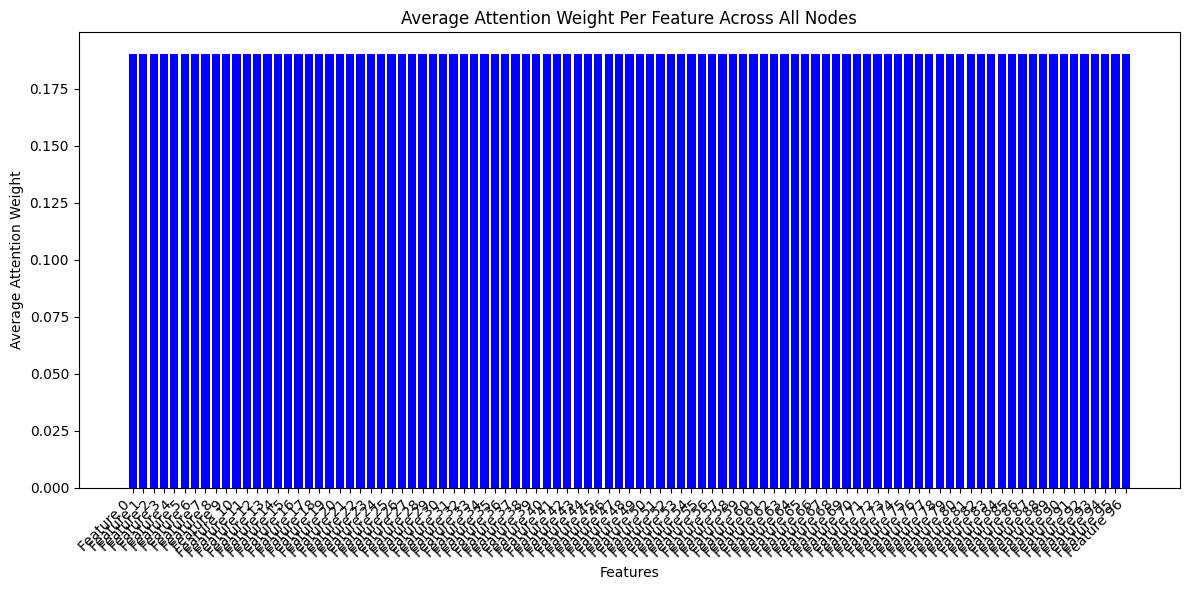

In [74]:
# Perform a forward pass to compute weights
custom_gat_model(data.x, data.edge_index)

# Example feature names
feature_names = [f'Feature {i}' for i in range(custom_gat_model.conv1.lin.in_features)]

# Visualize the average attention per feature
visualize_average_attention_per_feature(custom_gat_model, feature_names)

In [100]:
# Test the first model: CustomGAT, standard data, cross-entropy loss
print("Here are the values for the CustomGAT model with the standard cross-entropy loss: ")

metrics_custom_gat_model = test(custom_gat_model, data)
print()
print_metrics(metrics_custom_gat_model)

Here are the values for the CustomGAT model with the standard cross-entropy loss: 
Prediction Distribution: {0: 250, 1: 153}
Privileged Prediction Distribution: {0: 67, 1: 40}
Unprivileged Prediction Distribution: {0: 183, 1: 113}
Privileged Positive Prediction Rate: 0.37383177876472473
Unprivileged Positive Prediction Rate: 0.3817567527294159

SPD : -0.00792
OAED : 0.03018
EOD : 0.05924


Treatment Equality Difference : -0.46154
SP_Unprivileged : 0.38176
SP_Privileged : 0.37383


OAED_Unprivileged : 0.93243
OAED_Privileged : 0.96262
EOD_Unprivileged : 0.89076


EOD_Privileged : 0.95000
TED_Unprivileged : 0.53846
TED_Privileged : 1.00000


Accuracy : 0.72840


In [ ]:
SPD : -0.02842
OAED : -0.01822
EOD : -0.04748


Treatment Equality Difference : -0.01984
SP_Unprivileged : 0.36486
SP_Privileged : 0.33645


OAED_Unprivileged : 0.79392
OAED_Privileged : 0.77570
EOD_Unprivileged : 0.69748


EOD_Privileged : 0.65000
TED_Unprivileged : 0.69444
TED_Privileged : 0.71429


Accuracy : 0.71605

#### Second Fair GAT

In [48]:
# Instantiate the model, define loss function and optimizer
custom_gat_model_2 = CustomGAT(data.x, edge_index)
custom_gat_optimizer_2 = torch.optim.Adam(custom_gat_model_2.parameters(), lr=0.01)

In [49]:
training(model=custom_gat_model_2, data=data, optimizer=custom_gat_optimizer_2, fairness=True, alpha=0.1, beta=0.1, gamma=0.1, delta=0.1, epochs=100)

Epoch 0 | Loss: 2.773331642150879
Epoch 10 | Loss: 0.31782299280166626
Epoch 20 | Loss: 0.3180868625640869
Epoch 30 | Loss: 0.29893550276756287
Epoch 40 | Loss: 0.28631526231765747
Epoch 50 | Loss: 0.28105273842811584
Epoch 60 | Loss: 0.2770257592201233
Epoch 70 | Loss: 0.27365851402282715
Epoch 80 | Loss: 0.2707068622112274
Epoch 90 | Loss: 0.26821669936180115


In [50]:
# Test the second model: CustomGAT, FAIR cross-entropy loss
print("Here are the values for the CustomGAT model with the FAIR cross-entropy loss: ")

metrics_custom_gat_model_2 = test(custom_gat_model_2, data)

print_metrics(metrics_custom_gat_model_2)

Here are the values for the CustomGAT model with the FAIR cross-entropy loss: 
Prediction Distribution: {0: 26, 1: 377}
Privileged Prediction Distribution: {0: 7, 1: 100}
Unprivileged Prediction Distribution: {0: 19, 1: 277}
Privileged Positive Prediction Rate: 0.9345794320106506
Unprivileged Positive Prediction Rate: 0.9358108043670654
SPD : -0.00123
OAED : 0.01658
EOD : 0.01069


Treatment Equality Difference : -2.62500
SP_Unprivileged : 0.93581
SP_Privileged : 0.93458


OAED_Unprivileged : 0.78716
OAED_Privileged : 0.80374
EOD_Unprivileged : 0.96522


EOD_Privileged : 0.97590
TED_Unprivileged : 6.87500
TED_Privileged : 9.50000


Accuracy : 0.71605


In [114]:
# Test the second model: CustomGAT, FAIR cross-entropy loss
print("Here are the values for the CustomGAT model with the FAIR cross-entropy loss: ")

metrics_custom_gat_model_2 = test(custom_gat_model_2, data)

print_metrics(metrics_custom_gat_model_2)

Here are the values for the CustomGAT model with the FAIR cross-entropy loss: 
Prediction Distribution: {0: 245, 1: 158}
Privileged Prediction Distribution: {0: 68, 1: 39}
Unprivileged Prediction Distribution: {0: 177, 1: 119}
Privileged Positive Prediction Rate: 0.3644859790802002
Unprivileged Positive Prediction Rate: 0.40202704071998596
SPD : -0.03754
OAED : 0.00733
EOD : -0.00777


Treatment Equality Difference : 0.33333
SP_Unprivileged : 0.40203
SP_Privileged : 0.36449


OAED_Unprivileged : 0.94595
OAED_Privileged : 0.95327
EOD_Unprivileged : 0.93277


EOD_Privileged : 0.92500
TED_Unprivileged : 1.00000
TED_Privileged : 0.66667


Accuracy : 0.81481


In [ ]:
SPD : -0.02842
OAED : -0.01822
EOD : -0.04748


Treatment Equality Difference : -0.01984
SP_Unprivileged : 0.36486
SP_Privileged : 0.33645


OAED_Unprivileged : 0.79392
OAED_Privileged : 0.77570
EOD_Unprivileged : 0.69748


EOD_Privileged : 0.65000
TED_Unprivileged : 0.69444
TED_Privileged : 0.71429


Accuracy : 0.71605